# The C programming language

## Introduction and Motivation

Modern computational physics often demands both rapid prototyping and extreme computational efficiency.
While Python offers clarity and rapid development, its interpreted nature can introduce performance bottlenecks in computation-heavy tasks.
In this section, we discuss the historical context and practical reasons for incorporating the C programming language into your scientific computing toolbox.

### Why C?

When this note is written, C and C++ are the 4th and 2nd popular programming lagnauges on the [TIOBE Index](https://www.tiobe.com/tiobe-index).
There are many reasons contribute to its significance.

![Ken Thompson (left) with Dennis Ritchie (right)](figures/Thompson+Ritchie.jpg)

* **Historical Relevance and Impact**
  * Birth of Unix and C:
    C was developed in the early 1970s by Dennis Ritchie and played a critical role in the development of Unix.
    Its influence persists in virtually every modern operating system and programming language.
  * Foundational Influence:
    Many languages (like C++, Java, and even Python's CPython interpreter) are built on principles originating in C.
    Learning C gives you insight into the low-level operations that drive higher-level languages.

* **Performance Benefits**
  * Compiled Efficiency:
    C is a compiled language, meaning the code is translated directly into machine code before execution.
    This typically results in significant performance gains over interpreted languages.
  * Memory Management:
    With C, you have explicit control over memory allocation and deallocation.
    This low-level control can be crucial for optimizing large-scale simulations and numerical computations in physics.
  * Deterministic Behavior:
    C's simplicity and control mean that you can predict performance characteristics more accurately.
    For simulations or numerical integrations where timing and resource usage are critical, this predictability is a major advantage.

* **Practical Applications in Computational Physics**
  * High-Performance Libraries:
    Many of the core libraries used in computational physics (e.g., BLAS, LAPACK, FFTW) are written in C or have C interfaces.
    Understanding C can help you better leverage and even extend these libraries.
  * Embedded and Real-Time Systems:
    In areas like signal processing, control systems, and experimental setups, C is often the language of choice due to its speed and direct hardware interfacing.
  * Scalable Simulations:
    When simulations require thousands or millions of iterations (for example, in numerical integration of differential equations), the efficiency of C can be the difference between a simulation that runs in seconds versus one that runs in hours.

### When to Use C vs. Python

* **Complementary Roles in Scientific Computing**
  * Rapid Development vs. Execution Speed:
  * Python excels at quickly writing, testing, and iterating on code.
    Its syntax is clean and it offers a rich ecosystem for data manipulation and visualization.
  * C excels at executing performance-critical tasks.
    Once a prototype is validated in Python, rewriting the heavy computations in C (and call it from python) can drastically reduce runtime.

* **Trade-offs and Synergy**
  * Development Trade-offs:
    While Python minimizes the time to prototype, its interpreted nature means that it can be slower for loop-intensive computations or tasks that require fine-grained memory control.
    C, being low-level, requires more careful management of resources, but it pays off when performance is key.
  * Hybrid Approaches:
    In many scientific applications, a hybrid approach is used:
    * C for "Heavy Lifting":
      Writing the performance-critical portions (such as numerical integration, matrix operations, or simulation kernels) in C.
    * Python for Scripting and Visualization:
      Using Python to manage input/output, orchestrate simulations, and visualize results.
    This division of labor allows you to benefit from the best of both worlds—rapid development and high performance.

* **Example**
  * Many of the popular simulation codes are written in C/C++, e.g.,
    [Gadget](https://wwwmpa.mpa-garching.mpg.de/gadget4/),
    [AthenaK](https://github.com/IAS-Astrophysics/athenak).
  * While data visualization are written in python, e.g., [yt](https://yt-project.org/).

## Quick Example

To start with, let's compare directly a forward euler code written in Python and C:

Text(0, 0.5, 'x')

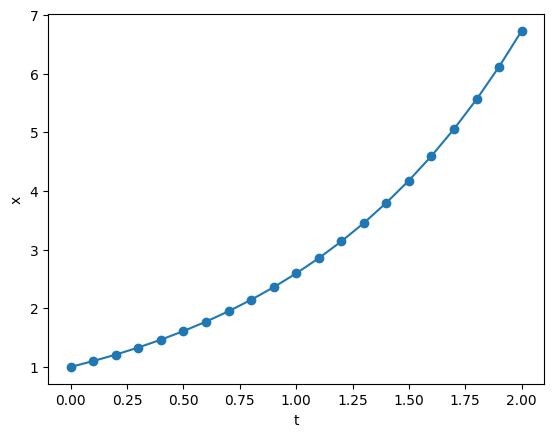

In [1]:
# This is the simple forward Euler example we used in ODE I:
# https://ua-2025q1-phys305.github.io/14/notes.html#example

from matplotlib import pyplot as plt

def forwardEuler(f, x, t, dt, n):
    T = [t]
    X = [x]
    for i in range(n):
        t += dt
        x += f(x) * dt
        T.append(t)
        X.append(x)
    return T, X

def f(x):
    return x

Tpy, Xpy = forwardEuler(f, 1, 0, 0.1, 20)

plt.plot(Tpy, Xpy, 'o-')
plt.xlabel('t')
plt.ylabel('x')

To translate it to C, it becomes something like:
```C
/* Place the following code in "example.c" */

#include <stdlib.h>
#include <stdio.h>

struct solution {
	double *T;
	double *X;
};

struct solution
forward_Euler(double (*f)(double), double x, double t, double dt, int n)
{
	double *T = (double *)malloc(sizeof(double) * (n+1));
	double *X = (double *)malloc(sizeof(double) * (n+1));

	T[0] = t;
	X[0] = x;

	for(int i = 1; i <= n; ++i) {
		t += dt;
		x += f(x) * dt;
		T[i] = t;
		X[i] = x;
	}

	struct solution s = {T, X};
	return s;
}

void
free_solution(struct solution s)
{
	free(s.T);
	free(s.X);
}

double f(double x)
{
	return x;
}

int main(int argc, char *argv[])
{
	int n = 20;
	struct solution s = forward_Euler(f, 1, 0, 0.1, n);

	for(int i = 0; i <= n; ++i)
		printf("%f %f\n", s.T[i], s.X[i]);

	free_solution(s);

	return 0;
}
```

This is not very elegant...
But before we dive into the details of the code, let's try to run it.

1. Copy and paste the above code block into a file called "example.c".
2. Run `gcc example.c -o example` in your terminal.
   You should a new file `example`.
3. Run the code by `./example`.
   It does not create any plot!
   Instead, just a list of numbers.
4. We may use python to create the plot.
   But this requires first saving the output to a file.
   Run `./example > data.txt`.
   Here, `>` is the bash redirection operator.
   It redirects the standard output of a program to a file.
6. Once "data.txt" is created, run the following python cell:

Text(0, 0.5, 'x')

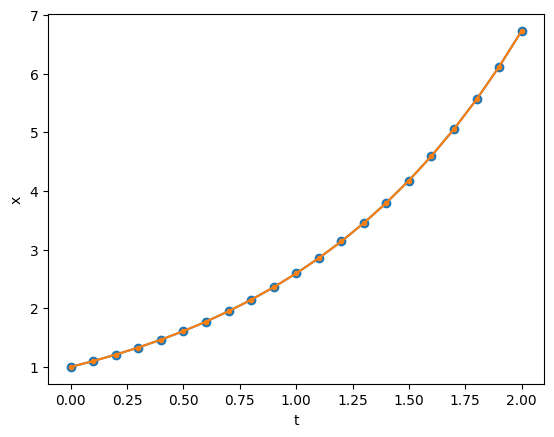

In [2]:
from numpy import genfromtxt

data = genfromtxt('data.txt')
TC = data[:,0]
XC = data[:,1]

plt.plot(Tpy, Xpy, 'o-')
plt.plot(TC,  XC,  '.-')
plt.xlabel('t')
plt.ylabel('x')

The C result agrees with the python result, as expected.

Let's now go through the compilation process and the code with more details.

## The C Programming Language

The best places to learn C are:

* [**The C Programming Language**](https://www.amazon.com/Programming-Language-2nd-Brian-Kernighan/dp/0131103628) by Brian W. Kernighan and Dennis M. Ritchie
* The [C-FAQ](https://c-faq.com)
* And high quanlity open source software including the [GNU Scientific Library](https://savannah.gnu.org/git/?group=gsl), [FFTW](https://github.com/FFTW/fftw3), and [Linux Kernel](https://github.com/torvalds/linux).

Many "modern C" books are full of errors, especially memory management.
Avoid them.

![C Book](figures/C-book.jpg)

### Python vs. C

Both Python and C are powerful languages, but they differ fundamentally in design, usage, and performance.
Here is a side-by-side comparison of common language constructs and a discussion of some deeper differences.

Python                     | C
:--                        | :--
`import package`           | `#include <package.h>` and then link with `gcc ... -lpackage`
Dynamic type               | Static type `int`, `double`, `char []`
`def func(): ...`          | `double func(double x) {...}`
Must use indentation       | Indentation optional; use `{...}` for block
New line for new statement | `;` to end a statement
`print(x)`                 | `printf("%d\n", x);`
`return x`                 | `return x;`
`if x == 1: ... else: ...` | `if (x == 1) {...} else {...}`
`for i in range(10): ...`  | `for (int i = 0; i < 10; ++i) {...}`
`/` vs `//` for divisions  | `/` behavior depends on type
`**` for power             | `#include <math.h>` and then use `pow(x, y)` for power; need to link with `gcc ... -lm`
`# ...` for comments       | `/* ... */` or `// ...` for comments

Deeper conceptual differences include:

* Multiple Return Values:
  * Python: Functions can return multiple values easily using tuples (e.g., `return (a, b, c)`).
  * C: Lacks built-in support for returning multiple values.
    You typically use pointers or define a struct to encapsulate multiple values.
    Tip: When designing numerical routines in C, consider how data is structured (e.g., using an array of structs vs. a struct of arrays) for performance and clarity.

* Memory Management:
  * Python: Manages memory automatically using garbage collection, manual deallocation (my `del`) is usually not needed.
  * C: Requires explicit memory management using functions like `malloc()` and `free()`.
    This provides greater control (and responsibility) over resource use—critical in high-performance simulations, where memory overhead and access patterns can significantly affect performance.

* Pointers:
  * Python: Abstracts away memory addresses; you don't need to deal with pointers directly.
  * C: Pointers are a fundamental concept, allowing you to directly manipulate memory.
    Mastery of pointers is essential for efficient data structures, interfacing with hardware, and optimizing numerical algorithms.

* Function Handling:
  * Python: Functions are first-class citizens;
    you can pass them around easily as arguments, return them from other functions, or store them in data structures.
  * C: While it does not have first-class functions in the same sense, C uses function pointers to allow similar patterns.
    Understanding function pointers is important for implementing callbacks and event-driven programming in low-level code.

* Program Structure and Entry Point:
  * Python: Code can run outside of functions and modules are executed as they are imported or run.
  * C: Every program must have an int main() function as its entry point.
    Although global variables are permitted, encapsulating logic within functions promotes better design and modularity.

## The Compilation Pipeline

A typical C program goes through several stages before becoming an executable:
* Preprocessing:
  The preprocessor handles directives (lines beginning with #), such as #include and #define.
  It expands macros and includes header files to produce a "translation unit" that is passed on to the compiler.
* Compilation:
  The compiler translates the preprocessed code into assembly language.
  It checks the syntax and converts high-level constructs into low-level instructions.
* Assembly:
  The assembler converts the assembly code into machine code (object code) stored in object files (typically with a `.o` extension).
* Linking:
  The linker combines one or more object files along with necessary libraries into a single executable.
  This step resolves external references (e.g., functions declared in libraries).

Visual Flow:
```
Source Code (.c)
    |
    v  Preprocessing (gcc -E)
Translation Unit (.i)
    |
    v  Compilation (gcc -S)
Assembly Code (.s)
    |
    v  Assembly (gcc -c)
Object File (.o)
    |
    v  Linking (gcc -o)
Executable
```

Which we may run as:
```bash
gcc example.c -E > example.i
gcc example.i -S
gcc example.s -c
gcc example.o -o example
```

### Using a C Compiler (e.g., gcc)

The GNU Compiler Collection (gcc) is a popular tool for compiling C programs. Here’s a common command used to compile a C program:
```bash
gcc example.c -o example -Wall -O2 -g
```

Let's break down what each part does:
* `example.c`:
  The source file containing your C code.
* `-o example`:
  Specifies the name of the output executable.
  Without this, gcc would default to an executable named `a.out`.
* `-Wall`:
  Enables all standard warnings.
  This helps catch potential issues early, ensuring higher code quality.
  I often also use `-Wextra` to print even more warnings.
  It may also be useful to inclue `-Werror` to treat all warnings as errors.
* `-O2`:
  Applies level 2 optimizations to the code.
  Optimization flags (`-O0`, `-O1`, `-O2`, `-O3`, or `-Ofast`) can greatly affect the performance of computationally intensive applications.
  In computational physics, even small speed-ups are important when scaling up simulations.
* `-g`:
  Generates debugging information.
  This is essential when using debugging tools like `gdb` to step through your code and diagnose issues.

On a Unix/Linux system,
```bash
ls /bin/lib
```
and you see a large number of files start with `lib`.
These are libraries that contains binaries of useful functions.
For example, `libm.so` include implementations of `sin()`, `cos()`, etc.

To use functions from a library, you first need to include a header file, e.g.,
```c
#include <math.h>
```
This will look for a file "math.h" in, typically, `/usr/include`.
You then need to link the math library with `-lm`.
Example:
```bash
gcc example.c -o example -Wall -O2 -lm
```

Many standard functions such as `malloc()`, `free()`, and `printf()`, are included in `libc`, which is linked by default.
Hence, there is no need to use `-lc`.
However, you are still require to inlcude the right header files such as `#include <stdlib.h>` and `#include <stdio.h>`.